# Skeleton plot that shows the arborization of all 6 clusters by Color
Steps in this file:
- Import skeleton, using 2d skeletons segments (kind of buggy)
- Import partition data for full connectome
- Import synapse location data
- Process dataframes so that synapse location and cluster are on the same dataframe
- Assign colors with a dictionary and then map
- Plot segments and synapses with legend

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client


auth_token_file = open("/Users/rhessa/flybrain-clustering/flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading BokehJS ...

In [2]:
from neuprint import fetch_synapse_connections, SynapseCriteria as SC, merge_neuron_properties, fetch_neurons

In [3]:
# Create skeleton for later usage (inspired from Prof G.'s notebook ovi_specs_sandbox.ipynb)
# body Ids of oviINs
ovi_r = 423101189
ovi_l = 485934965
ovis = [ovi_r, ovi_l]

# cretae skeleton for both oviINs
skeletons = []

for i in ovis:
    s = np_client.fetch_skeleton(i, format='pandas')
    s['bodyId'] = i
    s['color'] = bokeh.palettes.Greys[3][1]
    skeletons.append(s)

skeletons = pd.concat(skeletons, ignore_index=True)

In [4]:
# Join parent nodes
segments = skeletons.merge(skeletons, left_on=['bodyId', 'link'], right_on=['bodyId', 'rowId'], suffixes=['_child', '_parent'])

In [5]:
ovi_pre_syns = fetch_synapse_connections(None, ovis, SC(primary_only=True))
pre_neurons, _ = fetch_neurons(ovi_pre_syns['bodyId_pre'].unique())
ovi_pre_syns = merge_neuron_properties(pre_neurons, ovi_pre_syns, 'type')

  0%|          | 0/36631 [00:00<?, ?it/s]

/Users/rhessa/miniconda3/envs/flybrainlab/lib/python3.11/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


In [6]:
# import full connectome data and location data
ovi_node_df  = pd.read_csv('/Users/rhessa/flybrain-clustering/oviIN_combined/preprocessed-v1.2.1/preprocessed_nodes.csv')

# Import synapse location data for pre-synaptic sites
#ovi_pre_syns = pd.read_csv('/Users/rhessa/flybrain-clustering/ovi_pre_syns.csv', index_col=0)

In [7]:
ovi_pre_syns

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,type_post
0,989228019,423101189,CRE(R),CRE(R),22857,34611,17485,22825,34624,17464,0.998,0.633171,FB5V,oviIN
1,988909130,423101189,CRE(R),CRE(R),19523,31096,21707,19509,31112,21693,0.969,0.528840,FB5V,oviIN
2,988567837,423101189,LAL(R),LAL(R),23100,27659,23824,23074,27659,23801,0.970,0.459446,FB4G,oviIN
3,987842109,423101189,SMP(R),SMP(R),19041,33090,14598,19047,33072,14598,0.973,0.974019,None,oviIN
4,987273073,423101189,CRE(R),CRE(R),19347,27826,15348,19351,27806,15376,0.943,0.595921,None,oviIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36626,1008369339,485934965,SMP(L),SMP(L),31028,26185,15129,31005,26204,15116,0.986,0.482765,FS1B,oviIN
36627,1008369339,485934965,SMP(L),SMP(L),31144,26074,15107,31172,26062,15107,0.985,0.915252,FS1B,oviIN
36628,1008059095,485934965,SMP(L),SMP(L),31565,24018,14333,31582,23993,14322,0.808,0.331854,None,oviIN
36629,1008059095,485934965,SMP(L),SMP(L),27808,28086,13001,27808,28115,13002,0.984,0.968924,None,oviIN


In [8]:
# edit dataframes for easy merging
ovi_clusters = ovi_node_df[['id', '0.0']].copy()
ovi_locs = ovi_pre_syns[['bodyId_pre', 'x_pre', 'y_pre', 'z_pre']].copy()

# merge synapse data onto cluster data
ovi_plotting = ovi_clusters.merge(ovi_locs, left_on='id', right_on='bodyId_pre').drop(columns='bodyId_pre')
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre
0,1003215282,1,24301,16887,21862
1,1005952640,1,21998,15625,18990
2,1005952640,1,22998,15275,23049
3,1005952640,1,23034,15380,23131
4,1006928515,1,22664,14840,19749
...,...,...,...,...,...
36626,988567837,5,23100,27659,23824
36627,988653659,5,32159,33714,14593
36628,988654188,2,32142,33749,14468
36629,988909130,5,19523,31096,21707


In [9]:
# Create color dictionary where each number in column 0.0 is assigned a color
color_dict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'pink', 6: 'orange'}

# Merge color dictionary onto dataframe
ovi_plotting['color'] = ovi_plotting['0.0'].map(color_dict)
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre,color
0,1003215282,1,24301,16887,21862,red
1,1005952640,1,21998,15625,18990,red
2,1005952640,1,22998,15275,23049,red
3,1005952640,1,23034,15380,23131,red
4,1006928515,1,22664,14840,19749,red
...,...,...,...,...,...,...
36626,988567837,5,23100,27659,23824,pink
36627,988653659,5,32159,33714,14593,pink
36628,988654188,2,32142,33749,14468,blue
36629,988909130,5,19523,31096,21707,pink


(12840.15, 35430.85, 35193.2, 4542.8)

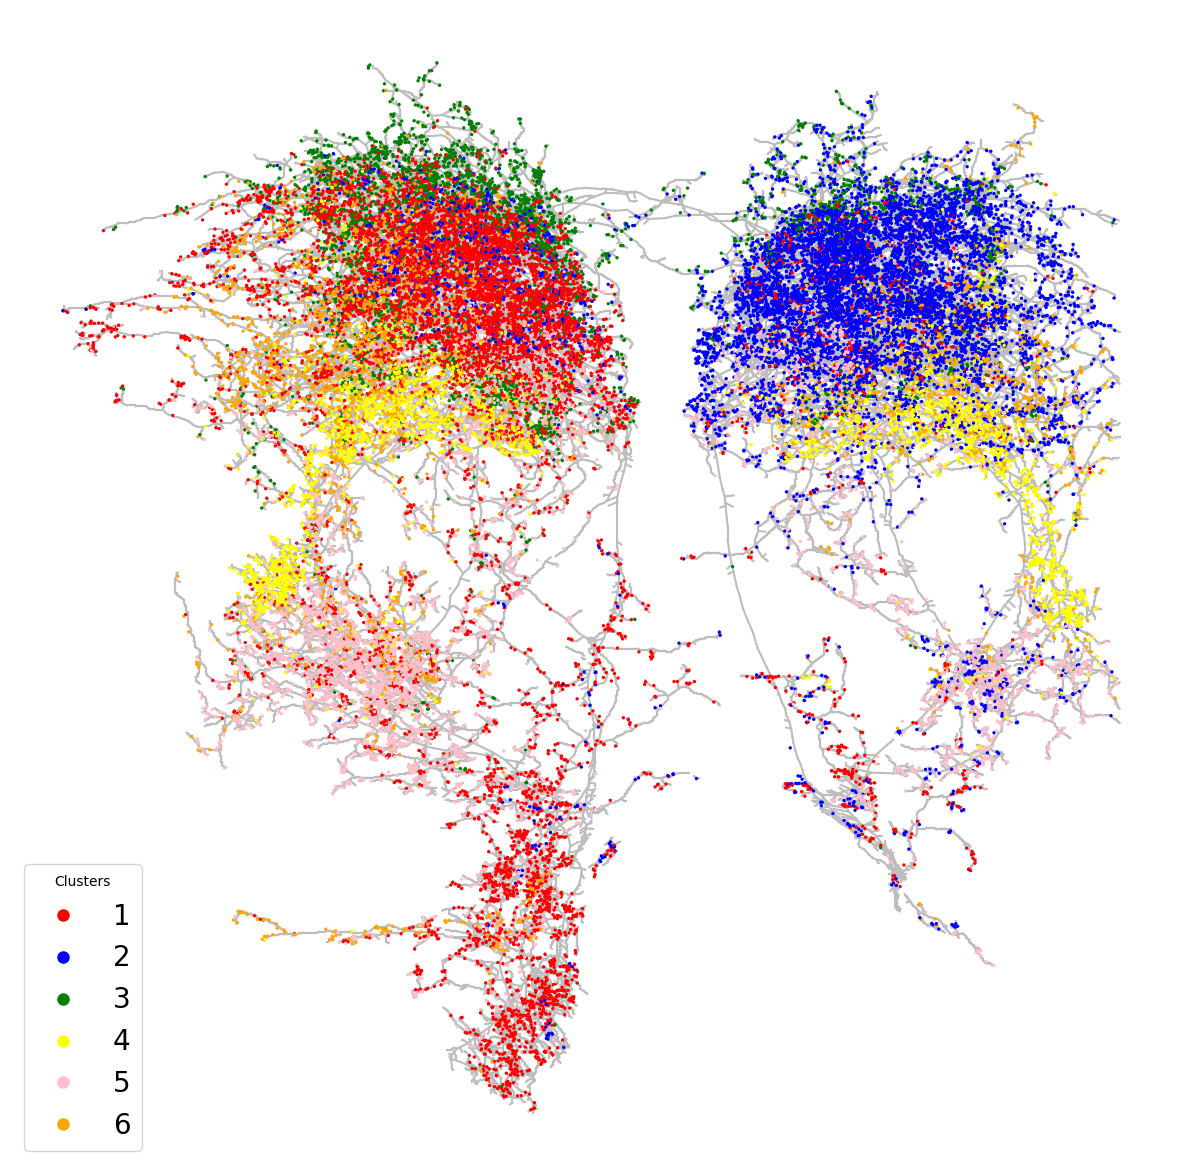

In [10]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# Drop axes 

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting['x_pre'], ovi_plotting['z_pre'], c=ovi_plotting['color'], s=2, zorder=2)
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='2'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='3'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='4'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='5'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='6')], title='Clusters',fontsize="20", loc='lower left')
plt.axis('off')
